# User Engagement Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_engagement = pd.read_csv('/Users/ultimateflexer/Desktop/Springboard/relax_challenge/takehome_user_engagement.csv', parse_dates=True, index_col='time_stamp')

In [3]:
df_user = pd.read_csv('/Users/ultimateflexer/Desktop/Springboard/relax_challenge/takehome_users.csv', encoding='latin-1')

In [4]:
df_engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [5]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In order to figure out user visitor frequency, I must group the users, group the dates by week, and find the total visits per week from the users.

In [6]:
# Group by user, week, and find the sum.
grouped_df = df_engagement.groupby('user_id').resample('1W').sum()

# Make sure to remove NaN values that would interfere with grouping.
grouped_df = grouped_df[grouped_df['user_id'].isnull()==False].drop('user_id',axis=1)
grouped_df.head(15)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1
        2014-01-19        0
        2014-01-26        0
        2014-02-02        0
        2014-02-09        3
        2014-02-16        2

In [7]:
# Find weeks that had 3 or more visits for every user.

active_users = grouped_df['visited'] >= 3

# Group by users and sum up the number of weeks that had 3 or more visits.

active_users = active_users.groupby(level=0).apply(np.sum)

# Remove any users that did not visit 3 or more times in one week and create dataframe of 
# active users.

active_users = active_users[active_users != 0]
active_users = pd.DataFrame(active_users, index=active_users.index)
active_users.columns = ['Active Weeks']
active_users.head()

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [8]:
# Create final dataframe for analysis. 
df = active_users.merge(df_user, left_index=True, right_on='object_id')
df.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [9]:
# Find data on active users.

act_user_data = active_users.merge(df_user, left_index=True, right_on='object_id')
act_user_data['Active'] = 1

#Add Active column to original data.

df_user['Active']=int(0)
df_user.iloc[list(act_user_data.index),10]=1
model_data = df_user.set_index('object_id').sort_index()

#Prep data for modeling by removing unecessary features.

model_data.drop(['name', 'email', 'last_session_creation_time',], axis=1, inplace=True)
date_feature = model_data.pop('creation_time')
model_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [10]:
# Fill all NaNs with 0s, fix values in 'invited_by_user_id', and one hot encode 'creation_source'

model_data['invited_by_user_id'] = model_data['invited_by_user_id'].fillna(0)
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)
model_data = pd.get_dummies(data=model_data, prefix = '', columns=['creation_source'])
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active,_GUEST_INVITE,_ORG_INVITE,_PERSONAL_PROJECTS,_SIGNUP,_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1,0,11,1,0,1,0,0,0,0
2,0,0,1,1,1,0,1,0,0,0
3,0,0,94,1,0,0,1,0,0,0
4,0,0,1,1,0,1,0,0,0,0
5,0,0,193,1,0,1,0,0,0,0


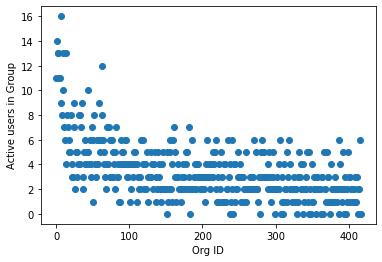

In [12]:
organized = model_data.groupby('org_id').sum()
plt.scatter(organized.index,organized.Active)
plt.ylabel('Active users in Group')
plt.xlabel('Org ID')
plt.show()

In [13]:
# Prep model.

org_active = []
for i in model_data['org_id']:
    cata = organized.loc[i,'Active']
    org_active.append(cata)
model_data['org_id'] = org_active

model_data = pd.get_dummies(data=model_data, columns=['org_id'])
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,_GUEST_INVITE,_ORG_INVITE,_PERSONAL_PROJECTS,_SIGNUP,_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Import modules from sklearn.

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

y = model_data.pop('Active')
X = model_data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [16]:
grb = GradientBoostingClassifier(max_features='sqrt')
parameter_grb = {'n_estimators':[40, 45, 50, 55, 60], 'learning_rate':[.01, 0.02, 0.03, 0.04, 0.05],
              'max_depth':[1, 2, 3, 4, 5]}
grid1 = GridSearchCV(estimator=grb, param_grid= parameter_grb,
                     scoring='accuracy', cv=5)
grid1.fit(X_train, y_train)
best_para_grb = grid1.best_params_
best_acc_grb = grid1.best_score_

print('The Tuned Paratmers :\n', best_para_grb, '\nAchieved %s Percent Accuracy' %(best_acc_grb*100))

The Tuned Paratmers :
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 45} 
Achieved 88.00000000000001 Percent Accuracy


In [17]:

gbm = GradientBoostingClassifier(max_features='sqrt',
                                 n_estimators=40, learning_rate=.01, max_depth= 1)
gbm.fit(X_train,y_train)

feature_coeff = pd.DataFrame(gbm.feature_importances_).transpose()
feature_coeff.columns = list(model_data.columns)
feature_coeff.index = ['GBM'] 
feature_coeff.transpose().sort_values(by='GBM', ascending=False)

,GBM
_PERSONAL_PROJECTS,0.391344
org_id_5,0.231557
org_id_1,0.099073
org_id_0,0.092543
org_id_6,0.068881
org_id_11,0.045484
org_id_12,0.023767
_SIGNUP_GOOGLE_AUTH,0.017047
_GUEST_INVITE,0.014522
org_id_13,0.007413


The above series is the level of importance for each feature, listed from most important to least important. Looking at 'creation_source_PERSONAL_PROJECTS', the most important feature,  it suggests that these are the users who are invited to join another user's personal workspace. Organization invited users also rank high on the list, which implies that users who joined vias these means are most likely to remain active. The list continues, and there are only 12 that have a value in general, so the rest are rather pointless to consider.